# Visual Pipelines 

This notebook demonstrates a proof of concept for a visual pipeline for analytics. 

![Yellowbrick Prototype Pipeline Objects](figures/pipeline_prototype.png)

In [219]:
%matplotlib inline

import os
import sys 

# Modify the path 
sys.path.append("..")

import numpy as np
import pandas as pd
import yellowbrick as yb 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

## Load Datasets 

Note that if datasets do not exist, please see the `download.py` located in this directory. 

In [220]:
FIXTURES  = os.path.join(os.getcwd(), "data")
credit    = pd.read_excel(os.path.join(FIXTURES, "credit.xls"), header=1)
concrete  = pd.read_excel(os.path.join(FIXTURES, "concrete.xls"))
occupancy = pd.read_csv(os.path.join('data','occupancy','datatraining.txt'))

In [221]:
# Rename the columns of the datasets for ease of use. 
credit.columns = [
    'id', 'limit', 'sex', 'edu', 'married', 'age', 'apr_delay', 'may_delay',
    'jun_delay', 'jul_delay', 'aug_delay', 'sep_delay', 'apr_bill', 'may_bill',
    'jun_bill', 'jul_bill', 'aug_bill', 'sep_bill', 'apr_pay', 'may_pay', 'jun_pay',
    'jul_pay', 'aug_pay', 'sep_pay', 'default'
]

concrete.columns = [
    'cement', 'slag', 'ash', 'water', 'splast',
    'coarse', 'fine', 'age', 'strength'
]

occupancy.columns = [
    'date', 'temp', 'humid', 'light', 'co2', 'hratio', 'occupied'
]


## Evaluation Visualization Prototype

In [222]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class VisualPipeline(Pipeline):
    
    def draw(self):
        """
        Calls the draw method on every visual transformer/estimator  
        """
        for name, estimator in self.steps:
            try:
                estimator.draw()
            except AttributeError:
                continue 

                
class ClassifierEvaluation(object):
    
    def draw(self):
        yb.crplot()

In [223]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 

model = Pipeline([
    ('scale', StandardScaler()), 
    ('model', LinearSVC())
])

model.steps

[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0))]

## `Visualizer` class

In base.py at the root of yellowbrick.

In [224]:
class Visualizer(BaseEstimator):
    """
    Base class for feature visualization and model visualization.
    
    Ensures that styling arguments are passed in.
    """
    
    def __init__(self, **kwargs):
        self.size  = kwargs.pop('size')
        self.color = kwargs.pop('color')
        
    def fit(self, X, y=None, **kwargs):
        """
        Fits a transformer to X and y 
        """
        pass
    
    def _draw(self, **kwargs):
        pass
    
    def poof(self, model=None):
        """
        Visualizes either data features 
        or fitted model scores
        """
        pass
    
    def fit_draw(self, X, y=None):
        """
        Fits a transformer to X and y then returns
        visualization of features or fitted model.
        """
        pass
    

## `FeatureVisualizer` base class

Comes between or at the end of transformers but before the estimator. 

In [225]:
class FeatureVisualizer(Visualizer, TransformerMixin):
    """
    Base class for feature visualization to investigate features 
    individually or together.
    
    FeatureVisualizer is itself a transformer so that it can be used in
    a Scikit-Learn Pipeline to perform automatic visual analysis during build.
    
    Accepts as input a DataFrame or Numpy array.
    """    
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **kwargs):
        pass
    
    def transform(self, X):
        pass
    
    def poof(self, data=None):
        """
        Visualize data features individually or together
        """
        pass
    
    def fit_draw(self, X, data=None):
        pass
    
    def fit_transform(self, X, data=None):
        pass

## `ScoreVisualizer` class for estimators

Base class to follow an estimator in a pipeline. Not a transformer. 

In [ ]:
class ScoreVisualizer(Visualizer):
    """
    Base class to follow an estimator in a visual pipeline.
    
    Draws the score for the fitted model.
    """
    
    def __init__(self, model):
        pass
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        pass
    
    def score(self, y, y_pred=None):
        """
        Score will call draw to visualize model performance.
        If y_pred is None, call fit-predict on the model to get a y_pred.
        """
        return self.draw(y,y_pred)

    def _draw(self, X, y):
        pass 
    
    def poof(self, **kwargs):
        """
        Poof calls render
        """
        pass



In [226]:
from yellowbrick.color_utils import ddlheatmap
from yellowbrick.utils import get_model_name, isestimator
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_fscore_support

class ClassificationScoreVisualizer(ScoreVisualizer):
    
    def __init__(self, model):
        """
        Check to see if model is an instance of a classifer.
        Should return a metrics mismatch error if it isn't.
        """
        pass

class ROCAUC(ClassificationScoreVisualizer):
    """
    Plot the ROC to visualize the tradeoff between the classifier's
    sensitivity and specificity.
    """
    def __init__(self, model, **kwargs):
        """
        Pass in a model to generate a ROC curve.
        """
        self.estimator = model
        self.name = get_model_name(self.estimator)
        super(ROCAUC, self).__init__(model, **kwargs)
        self.colors = {
            'roc': kwargs.pop('roc_color', '#2B94E9'),
            'diagonal': kwargs.pop('diagonal_color', '#666666'),
        }

        
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    def score(self, y, y_pred=None):
        self.fpr, self.tpr, self.thresholds = roc_curve(y, y_pred)
        self.roc_auc = auc(self.fpr, self.tpr)
        self._draw(y, y_pred)
        
    def _draw(self, y, y_pred):
        """
        Renders ROC-AUC plot.
        Called internally by score, possibly more than once
        """
        plt.figure()    
        plt.plot(self.fpr, self.tpr, c=self.colors['roc'], label='AUC = {:0.2f}'.format(self.roc_auc))

        # Plot the line of no discrimination to compare the curve to.
        plt.plot([0,1],[0,1],'m--',c=self.colors['diagonal'])


    def poof(self, **kwargs):
        """        
        Called by user.
        
        Only takes self.
        
        Take in the model as input and generates a plot of
        the ROC plots with AUC metrics embedded.
        """
        plt.title('ROC for {}'.format(self.name))
        plt.legend(loc='lower right')

        plt.xlim([-0.02,1])
        plt.ylim([0,1.1])

        return plt

class ClassificationReport(ClassificationScoreVisualizer):
    """
    Classification report that shows the precision, recall, and F1 scores
    for the model. Integrates numerical scores as well color-coded heatmap.
    """
    def __init__(self, model, **kwargs):
        """
        Pass in a fitted model to generate a ROC curve.
        """
        self.estimator = model
        self.name = get_model_name(self.estimator)
        self.cmap = kwargs.pop('cmap', ddlheatmap)
        self.classes = model.classes_

        
    def score(self, y, y_pred=None, **kwargs):
        """
        Generates the Scikit-Learn classification_report
        """
        self.keys = ('precision', 'recall', 'f1')
        self.scores = precision_recall_fscore_support(y, y_pred, labels=self.classes)
        self.scores = map(lambda s: dict(zip(self.classes, s)), self.scores[0:3])
        self.scores = dict(zip(self.keys, self.scores))  
        self._draw(y, y_pred)

        
    def _draw(self, y, y_pred):
        """
        Renders the classification report across each axis.
        """        
        fig, ax = plt.subplots(1)

        self.matrix = []
        for cls in self.classes:
            self.matrix.append([self.scores['precision'][cls],self.scores['recall'][cls],self.scores['f1'][cls]])
       
        for column in range(len(self.matrix)+1):
            for row in range(len(self.classes)):   
                ax.text(column,row,self.matrix[row][column],va='center',ha='center')

        fig = plt.imshow(self.matrix, interpolation='nearest', cmap=self.cmap)
        return ax


    def poof(self):
        """
        Plots a classification report as a heatmap.
        """
        plt.title('{} Classification Report'.format(self.name))
        plt.colorbar()
        x_tick_marks = np.arange(len(self.classes)+1)
        y_tick_marks = np.arange(len(self.classes))
        plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
        plt.yticks(y_tick_marks, self.classes)
        plt.ylabel('Classes')
        plt.xlabel('Measures')

        return plt

In [227]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

X = occupancy[['temp','humid','light','co2','hratio']]
y = occupancy['occupied']

In [228]:
model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

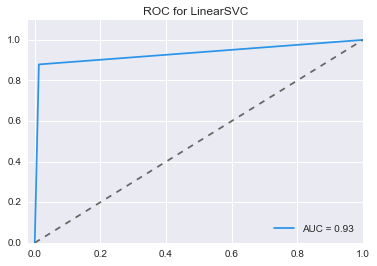

In [229]:
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.poof() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

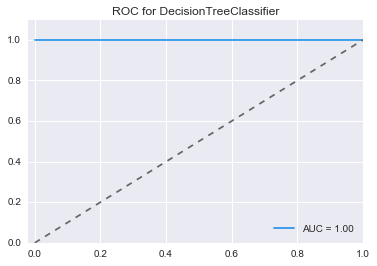

In [230]:
model = DecisionTreeClassifier()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.poof() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

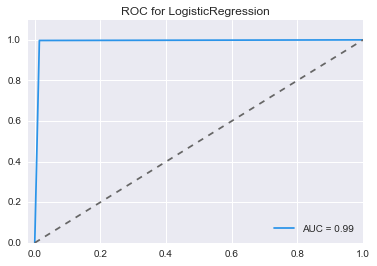

In [231]:
model = LogisticRegression()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.poof() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

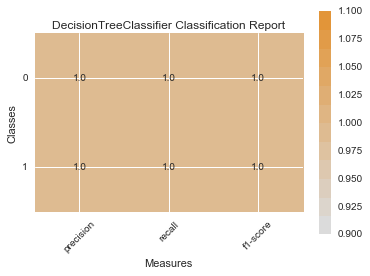

In [233]:
model = DecisionTreeClassifier()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.poof() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

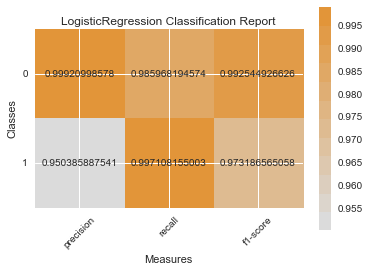

In [232]:
model = LogisticRegression()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.poof() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

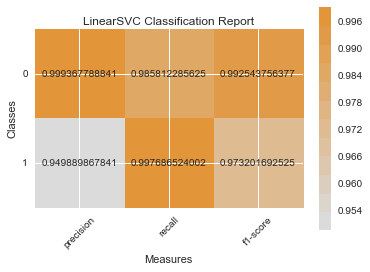

In [234]:
model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.poof() 